In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch
from torchvision import transforms
from face_alignment import align
from backbones import get_model
from sklearn.metrics.pairwise import cosine_similarity
from ultralytics import YOLO
from PIL import Image

e:\synclabs\edgeface\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Load a COCO-pretrained YOLOv8n model
yolo_model = YOLO("yolo11n.pt")
yolo_model = yolo_model.to(device)  # Move the model to GPU if available
## the other model
face_model_name="edgeface_xs_gamma_06" # or edgeface_xs_gamma_06
face_model=get_model(face_model_name)
checkpoint_path=f'checkpoints/{face_model_name}.pt'
face_model.load_state_dict(torch.load(checkpoint_path, map_location='cuda'))
face_model.to(device)  # Move the model to GPU if available
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
            ])

In [4]:
# Check the device for yolo_model
yolo_device = next(yolo_model.model.parameters()).device
print(f"YOLO model is on device: {yolo_device}")
# Check the device for face_model
face_device = next(face_model.parameters()).device
print(f"Face model is on device: {face_device}")

YOLO model is on device: cuda:0
Face model is on device: cuda:0


In [5]:
input_image_path = "new_test/office2.jpg"

In [ ]:
# Load the image using PIL
image = Image.open(input_image_path)


0: 384x640 6 persons, 2 ties, 55.8ms
Speed: 3.9ms preprocess, 55.8ms inference, 116.6ms postprocess per image at shape (1, 3, 384, 640)


In [7]:
def get_bboxes(image,  person_class = 0):
    results = yolo_model(image)
    idxes = torch.where(results[0].boxes.cls == person_class)
    bboxes = results[0].boxes.xyxy[idxes]
    return bboxes
    
def crop_image_from_bbox(image, bbox):
    """
    Crop a region from a PIL image using a bounding box.
    bbox: [x1, y1, x2, y2] in pixel coordinates
    """
    x1, y1, x2, y2 = map(int, bbox)
    return image.crop((x1, y1, x2, y2))

In [36]:
def get_embeddings(image):
    bboxes = get_bboxes(image)
    # Example: crop the first detected person
    transformed_faces = []
    idexes = []
    for idx, bbox in enumerate(bboxes):
        cropped_person = crop_image_from_bbox(image, bbox)
        aligned_face = align.get_aligned_face_from_image(cropped_person)
        try:
            transformed_face = transform(aligned_face)
            # print(f"Transformed face size: {transformed_face.size()}")
            transformed_faces.append(transformed_face)
            idexes.append(idx)
        except Exception as e:
            # print("Error transforming face, skipping this one.")
            continue

    if transformed_faces:
        transformed = torch.stack(transformed_faces)
        idxes = torch.tensor(idexes)
        transformed = transformed.to(device) # Move to GPU if available
    else:
        transformed = torch.empty(0, 3, 112, 112)
    embeddings = face_model(transformed)
    return embeddings, bboxes, idxes

In [43]:
def get_single_emb(image_path):
    aligned = align.get_aligned_face(image_path) # align face
    transformed_input = transform(aligned)
    transformed_input = transformed_input.to(device)
    emb = face_model(transformed_input.unsqueeze(0))
    return emb

In [44]:
source_embeddings = get_single_emb("new_test/steve.JPG")

In [47]:
emb, bboxes, idxes = get_embeddings(image)


0: 384x640 6 persons, 2 ties, 20.0ms
Speed: 2.6ms preprocess, 20.0ms inference, 3.7ms postprocess per image at shape (1, 3, 384, 640)
Face detection Failed due to error.
list index out of range
Face detection Failed due to error.
list index out of range


In [48]:
# Compute cosine similarity between emb and source_embeddings
cos_sim = torch.nn.functional.cosine_similarity(emb, source_embeddings)
# Find the index of the maximum similarity
best_match_idx = torch.argmax(cos_sim)
print("Cosine similarity:", cos_sim)
print("Best match index:", best_match_idx.item())

Cosine similarity: tensor([ 0.1687, -0.1018,  0.3361,  0.0214], device='cuda:0', grad_fn=<SumBackward1>)
Best match index: 2


In [52]:
best_box = bboxes[idxes[best_match_idx.item()]]
final_image = crop_image_from_bbox(image, best_box)

In [56]:
def find_person(image_path, person_image_path):
    image = Image.open(image_path)
    source_embeddings = get_single_emb(person_image_path)
    emb, bboxes, idxes = get_embeddings(image)
    
    if emb.numel() == 0:
        print("No faces detected in the image.")
        return None
    
    cos_sim = torch.nn.functional.cosine_similarity(emb, source_embeddings)
    best_match_idx = torch.argmax(cos_sim)
    # print("Cosine similarity:", cos_sim)
    # print("Best match index:", best_match_idx.item())
    
    best_box = bboxes[idxes[best_match_idx.item()]]
    final_image = crop_image_from_bbox(image, best_box)
    
    # plt.imshow(final_image)
    # plt.axis('off')
    # plt.show()
    
    return final_image


0: 384x640 6 persons, 2 ties, 22.4ms
Speed: 1.6ms preprocess, 22.4ms inference, 3.7ms postprocess per image at shape (1, 3, 384, 640)
Face detection Failed due to error.
list index out of range
Face detection Failed due to error.
list index out of range


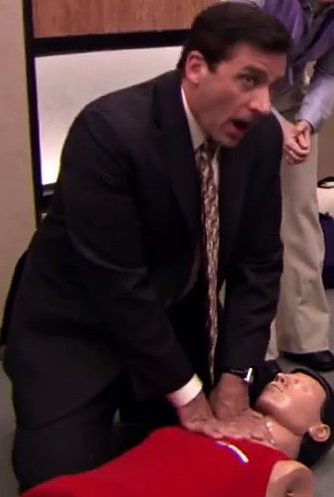

In [57]:
find_person("new_test/office2.jpg", "new_test/steve.JPG")

torch.Size([4, 512])

In [19]:
from PIL import ImageDraw

draw = ImageDraw.Draw(image)
boxes = results[0].boxes.xyxy.cpu().numpy()
classes = results[0].boxes.cls.cpu().numpy()

for box, cls in zip(boxes, classes):
    if int(cls) == 0:  # 0 is the label for person in COCO
        print(f"Detected person box: {box}")
        x1, y1, x2, y2 = box[:4]
        draw.rectangle([x1, y1, x2, y2], outline="red", width=3)

image.show()

Detected person box: [     1014.6      107.22      1200.8      476.72]
Detected person box: [     806.63       97.83      1019.2      481.14]
Detected person box: [     273.93      169.92         608      666.91]
Detected person box: [     492.47      67.367      656.61      544.34]
Detected person box: [     1194.2      132.68      1279.5       421.2]
Detected person box: [     930.87       359.7      1278.9      706.53]
